# Multiclass Semantic Segmentation (Radiographs- 135 Images) 

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
import pandas as pd

#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
#from tensorflow.layers import conv2d_transpose
from tensorflow.python.keras import losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

### Enabling Eager Execution

### Enviroment Checks

In [2]:
print(tf.__version__)

2.1.0


In [4]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [5]:
print(tf.executing_eagerly())

True


## Extract Target Class Definitions

### Function to parse the file "label_colors.txt" which contains the class definitions

In [3]:
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

### Parse and extract label names and codes

In [ ]:
label_codes, label_names = zip(*[parse_code(l) for l in open("label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

In [8]:
label_codes ,label_names 

([(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255)],
 ['Background', 'Red', 'Green', 'Blue'])

### Create useful label and code conversion dictionaries
_These will be used for:_
- One hot encoding the mask labels for model training
- Decoding the predicted labels for interpretation and visualization

In [9]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [10]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

## Masks conversions

### Extract _True Mask_ from a given mask
Incoming mask contains all set of pixel values so convert it into a mask containing only colors corresponnding to defined classes

In [11]:
def trueMask(rgb_mask):
#removing all other pixels
    rgb_mask[rgb_mask<200] = 0
    rgb_mask[rgb_mask >= 200] = 255
    rgb_mask[rgb_mask<255] = 0

#removing white pixels
    summed=np.sum(rgb_mask,axis=2)
    for i in range(summed.shape[0]):
        for j in range(summed.shape[1]):
            if summed[i][j]> 255:
                rgb_mask[i,j,:]=0
    return rgb_mask

### Conversion of rgb mask into one-hot encoded labels

In [12]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    rgb_image = trueMask(rgb_image)
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image

### Conversion of one-hot encoded labels into rgb mask

In [13]:
def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

## Creating Custom DataGenerator with real time augmentation

### Defining DataGenerator and augmentations

In [14]:
# Normalizing only frame images, since masks contain label info

#---------------------------------- changed  range from 0.2 to 0.3 ----------------------------------#
data_gen_args = dict(rescale=1./255,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',cval = 0)

data_gen_args1 = dict(rescale=1./255)

mask_gen_args = dict(
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',cval = 0)

mask_gen_args1 = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args1)
val_masks_datagen = ImageDataGenerator(**mask_gen_args1)

# Seed defined for aligning images and their masks
seed = 1

### Custom image data generators for creating batches of frames and masks

In [15]:
def TrainAugmentGenerator(seed = 1, batch_size = 8):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    'C_Data/RadioTrain_frames/',
    batch_size = batch_size, seed = seed)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    'C_Data/RadioTrain_masks/',
    batch_size = batch_size, seed = seed)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(seed = 1, batch_size = 8):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    'C_Data/RadioVal_frames/',
    batch_size = batch_size, seed = seed)


    val_mask_generator = val_masks_datagen.flow_from_directory('C_Data/RadioVal_masks/',
    batch_size = batch_size, seed = seed)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)
        


## Defining U-Net model for semantic segmentation

In [16]:
def get_small_unet(n_filters = 16, bn = True, dilation_rate = 1):
    '''Validation Image data generator
        Inputs: 
            n_filters - base convolution filters
            bn - flag to set batch normalization
            dilation_rate - convolution dilation rate
        Output: Unet keras Model
    '''
    #Define input batch shape
    batch_shape=(256,256,3)
    inputs = Input(batch_shape=(8, 256, 256, 3))
    print(inputs)
    
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
    if bn:
        conv1 = BatchNormalization()(conv1)
        
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv1)
    if bn:
        conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)

    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool1)
    if bn:
        conv2 = BatchNormalization()(conv2)
        
    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv2)
    if bn:
        conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)

    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool2)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv3)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)

    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool3)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv4)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool4)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv5)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv10 = Conv2D(4 * 1, (1, 1), activation='softmax', padding = 'same', dilation_rate = dilation_rate)(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model

## Generating U-Net model 

In [17]:
model = get_small_unet(n_filters = 32)

Tensor("input_1:0", shape=(8, 256, 256, 3), dtype=float32)


## Defining Losses and Metrics 

### Dice coefficient / F1 score

In [18]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

### Tversky Loss
If beta is 0.5 then Tversky Loss becomes Dice Loss

In [19]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

### mIoU / Jaccard Loss

In [20]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    # Arguments
        y_true: The ground truth tensor.
        y_pred: The predicted tensor
        smooth: Smoothing factor. Default is 100.
    # Returns
        The Jaccard distance between the two tensors.
    # References
        - [What is a good evaluation measure for semantic segmentation?](
           http://www.bmva.org/bmvc/2013/Papers/paper0032/paper0032.pdf)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [21]:
def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X &amp; Y|)/ (|X or Y|)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection     
    return (intersection + smooth) / ( union + smooth)

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

In [22]:
def mean_iou_np(y_true, y_pred):
    num = np.sum(np.logical_and(y_true, y_pred))
    den = np.float(np.sum(np.logical_or(y_true, y_pred)))
    if num < 5 and den < 5 or den == 0:
        return 1
    miou = num / den

    return miou

In [23]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# Load Model

In [24]:
model.load_weights("Unet_new_data_bc_8_200_80_epochs.h5")

## Compiling model
- Using categorical crossentropy loss since labels have been one hot encoded

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tversky_loss,dice_coef,'accuracy'])

#### Displaying summary of model

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(8, 256, 256, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (8, 256, 256, 32)    896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (8, 256, 256, 32)    128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (8, 256, 256, 32)    9248        batch_normalization[0][0]        
______________________________________________________________________________________________

## Define model callback settings

In [27]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='segmentation_model_20_epochs_checkpoint.h5', monitor='acc', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_acc', patience=10, verbose=1)
callbacks = [tb, mc, es]

## Train and save the model

### Initializing parameters

#### Batchsize

In [28]:
batch_size = 8

#### steps_per_epoch (usually equals to TotalTrainingSamples / TrainingBatchSize)

In [29]:
steps_per_epoch = 200

#### validation_steps (usually equals to TotalvalidationSamples / ValidationBatchSize)

In [30]:
validation_steps = 32/8

#### Epochs

In [31]:
num_epochs = 40

### Train Model

In [ ]:
'''
result = model.fit_generator(TrainAugmentGenerator(),
                             steps_per_epoch=steps_per_epoch,
                             validation_data = ValAugmentGenerator(),
                             validation_steps = validation_steps,
                             epochs=num_epochs,callbacks=callbacks)
                             

'''
result = model.fit_generator(TrainAugmentGenerator(),
                             steps_per_epoch=steps_per_epoch,
                             validation_data = ValAugmentGenerator(),
                             validation_steps = validation_steps,
                             epochs=num_epochs)

#callbacks=callbacks
model.save_weights("Unet_new_data_bc_8_200_120_epochs.h5", overwrite=True)

Epoch 1/40
Found 144 images belonging to 1 classes.
Found 144 images belonging to 1 classes.


W0810 13:46:42.407497 139653094741760 deprecation.py:323] From /home/ubuntu/anaconda3/envs/segmentation/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


199/200 [============================>.] - ETA: 2s - loss: 0.0182 - tversky_loss: 3.0210 - dice_coef: 0.9896 - acc: 0.9930Found 32 images belonging to 1 classes.
Found 32 images belonging to 1 classes.
200/200 [==============================] - 421s 2s/step - loss: 0.0182 - tversky_loss: 3.0210 - dice_coef: 0.9896 - acc: 0.9930 - val_loss: 0.1050 - val_tversky_loss: 3.0610 - val_dice_coef: 0.9541 - val_acc: 0.9736
Epoch 2/40
200/200 [==============================] - 391s 2s/step - loss: 0.0218 - tversky_loss: 3.0229 - dice_coef: 0.9883 - acc: 0.9923 - val_loss: 0.0931 - val_tversky_loss: 3.0597 - val_dice_coef: 0.9574 - val_acc: 0.9743
Epoch 3/40
200/200 [==============================] - 377s 2s/step - loss: 0.0243 - tversky_loss: 3.0244 - dice_coef: 0.9875 - acc: 0.9918 - val_loss: 0.0970 - val_tversky_loss: 3.0716 - val_dice_coef: 0.9508 - val_acc: 0.9697
Epoch 4/40
200/200 [==============================] - 378s 2s/step - loss: 0.0214 - tversky_loss: 3.0224 - dice_coef: 0.9886 - a

## Model evaluation

### Model evaluation historical plots

In [ ]:
# Get actual number of epochs model was trained for
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), result.history["acc"], label="train_accuracy")
plt.plot(np.arange(0, N), result.history["val_acc"], label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

#### Extract and display model frame, prediction and mask batch

In [32]:
testing_gen = ValAugmentGenerator(batch_size=32)

In [33]:
batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)

Found 32 images belonging to 1 classes.
Found 32 images belonging to 1 classes.


(32, 256, 256, 4)

#### Converting predictions into one-hot tensor

In [34]:
pred = np.array([ np.argmax(pred_all, axis=-1)==i for i in range(4) ]).transpose(1,2,3,0)

In [35]:
y_p = pred.astype(uint8)

### Displaying results

W0809 17:07:08.524307 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:08.543783 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


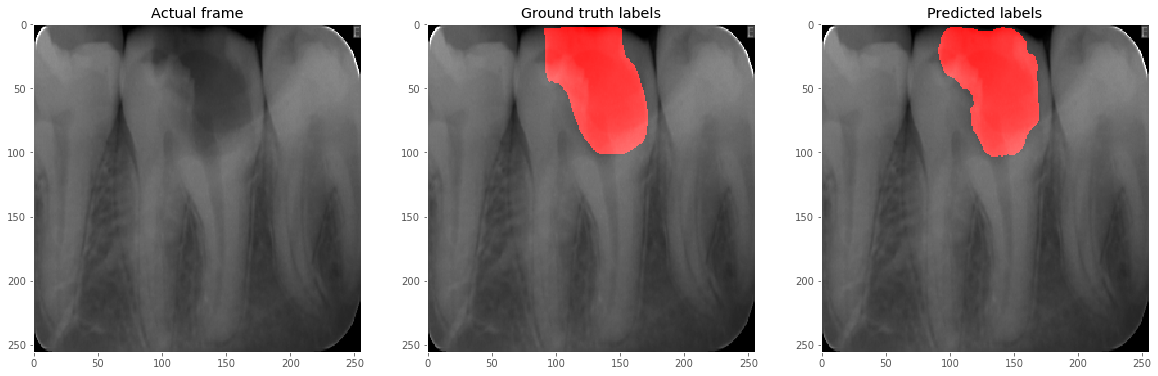

W0809 17:07:09.243347 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:09.262989 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


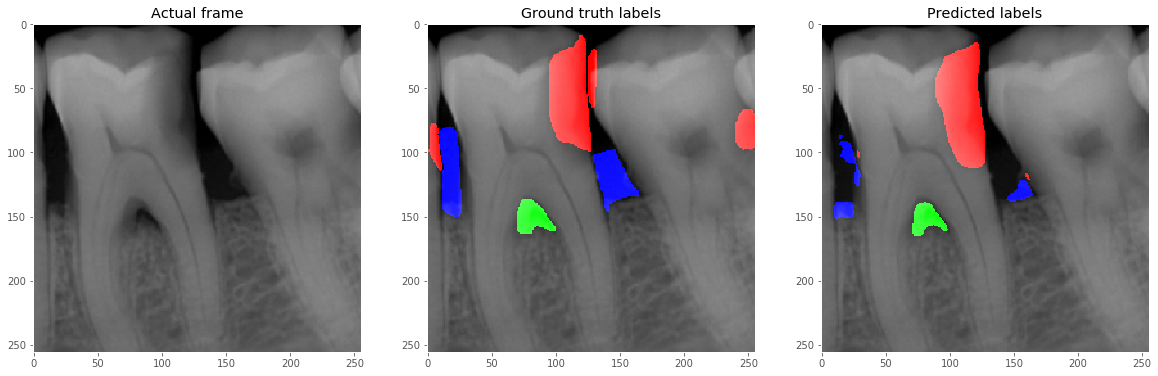

W0809 17:07:09.839949 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:09.864788 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


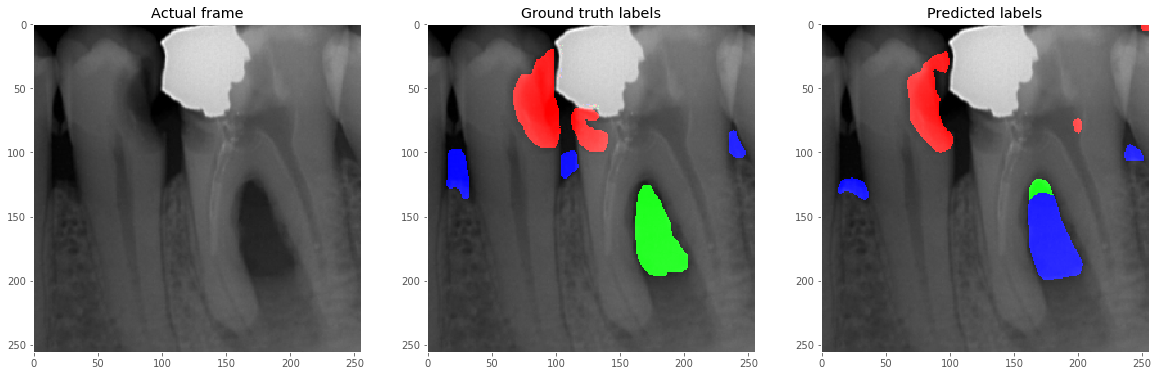

W0809 17:07:10.479866 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:10.507141 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


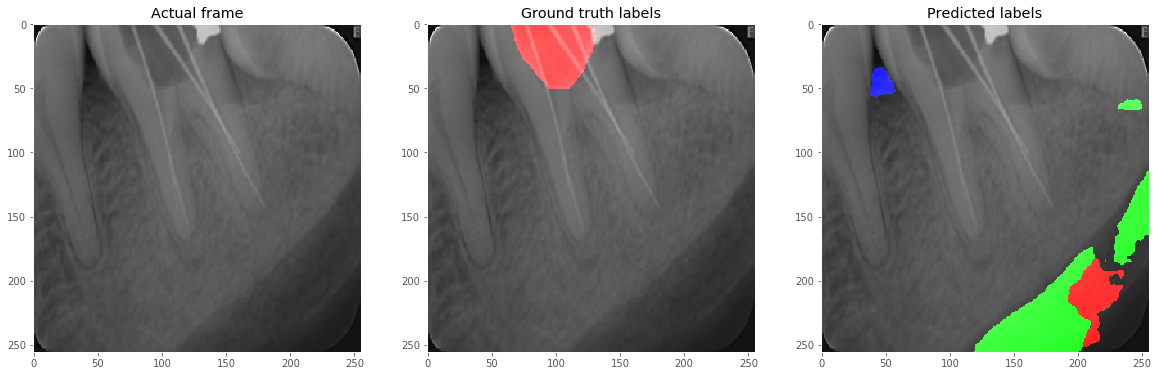

W0809 17:07:11.093912 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:11.146459 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


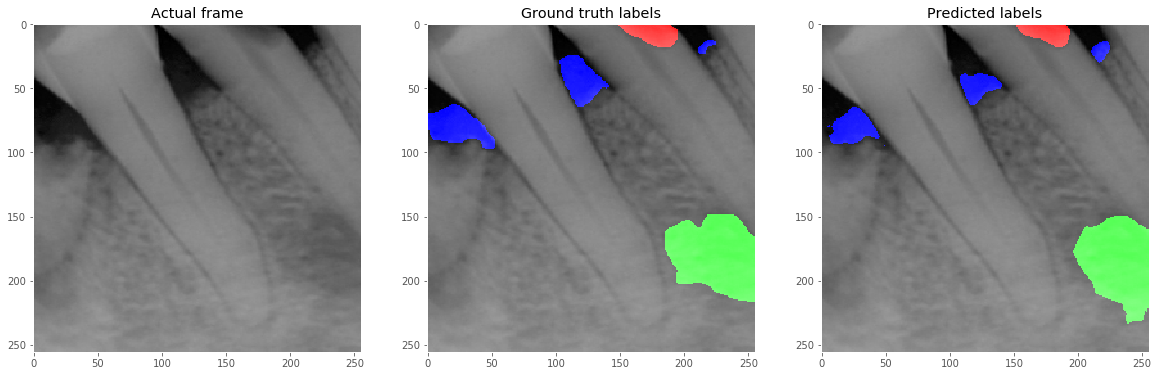

W0809 17:07:11.748227 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:11.779779 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


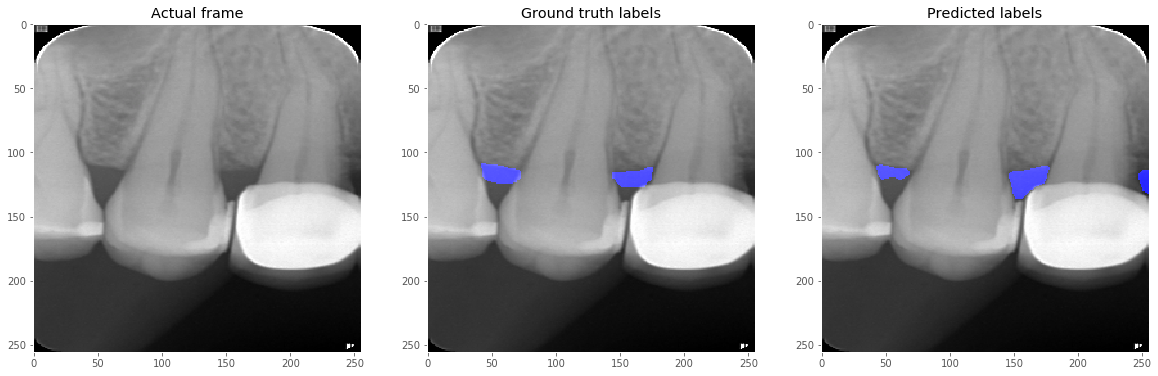

W0809 17:07:12.393551 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:12.416820 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


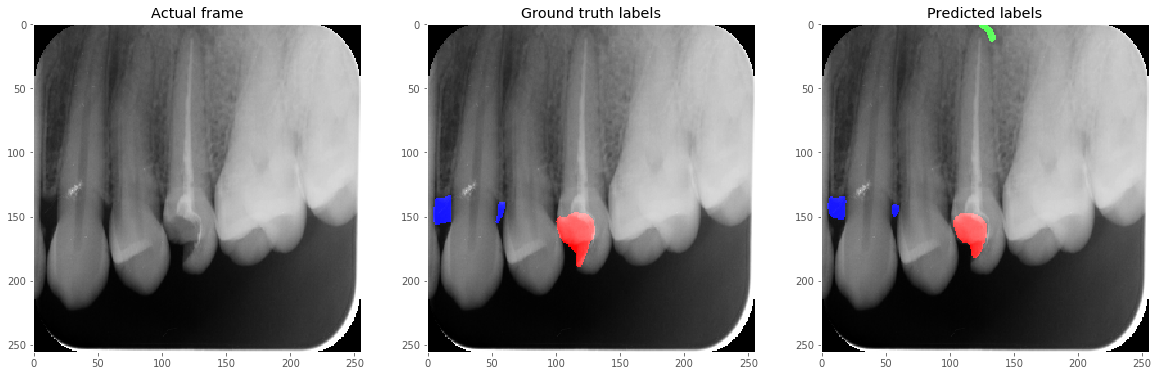

W0809 17:07:12.978160 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:12.995779 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


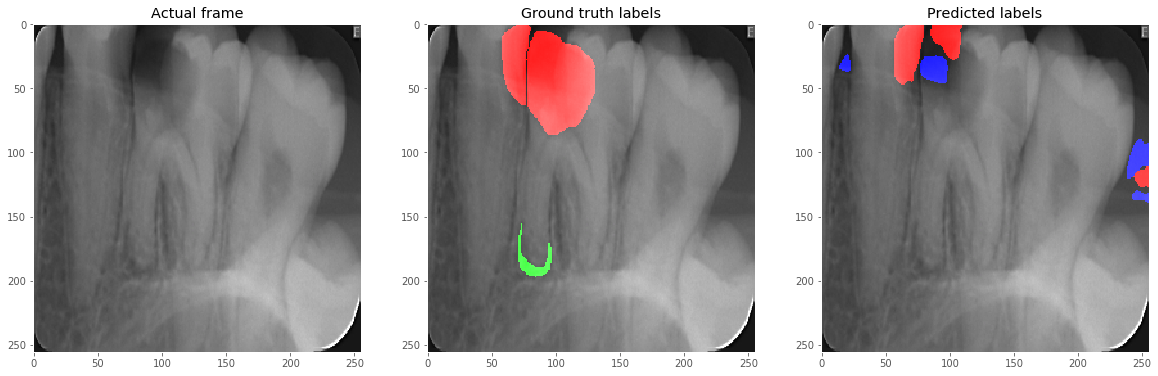

W0809 17:07:13.559933 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:13.581084 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


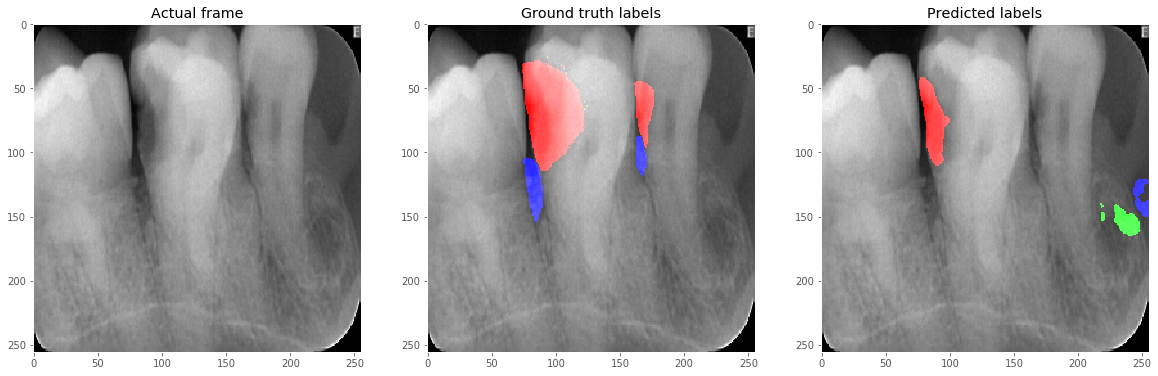

W0809 17:07:14.204472 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:14.245220 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


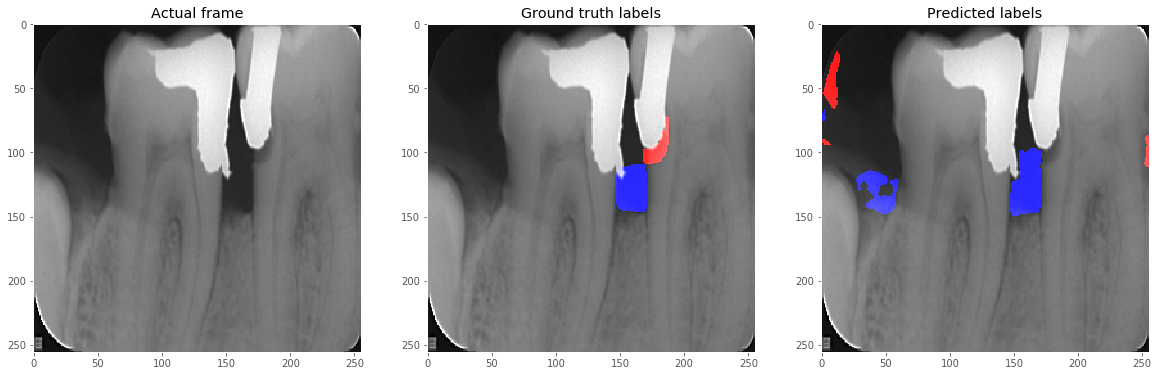

W0809 17:07:14.974304 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:14.997889 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


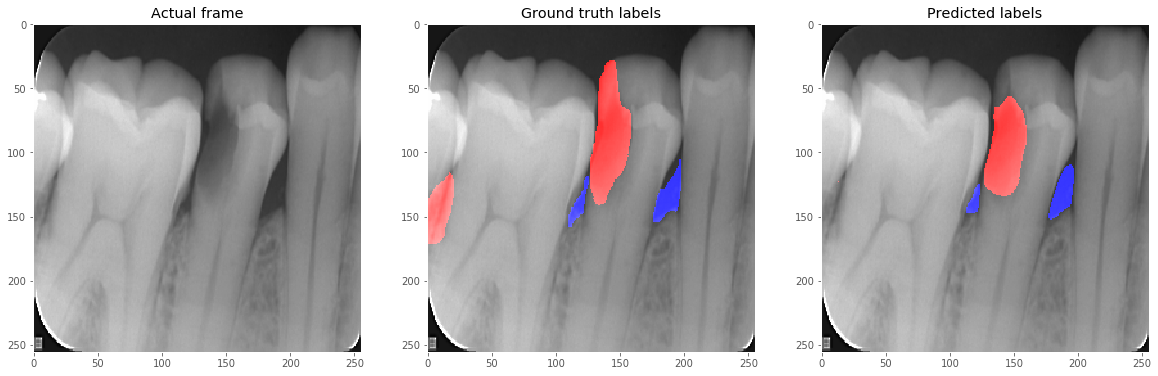

W0809 17:07:15.747696 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:15.769050 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


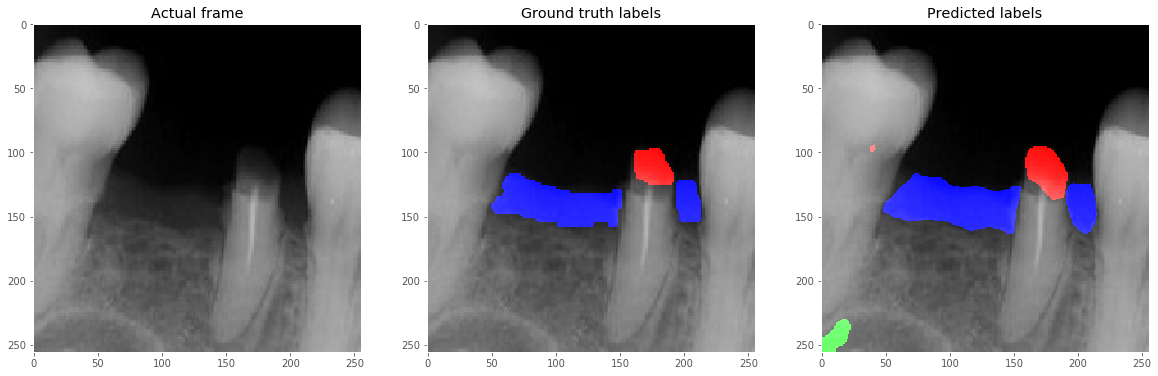

W0809 17:07:16.381356 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:16.398977 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


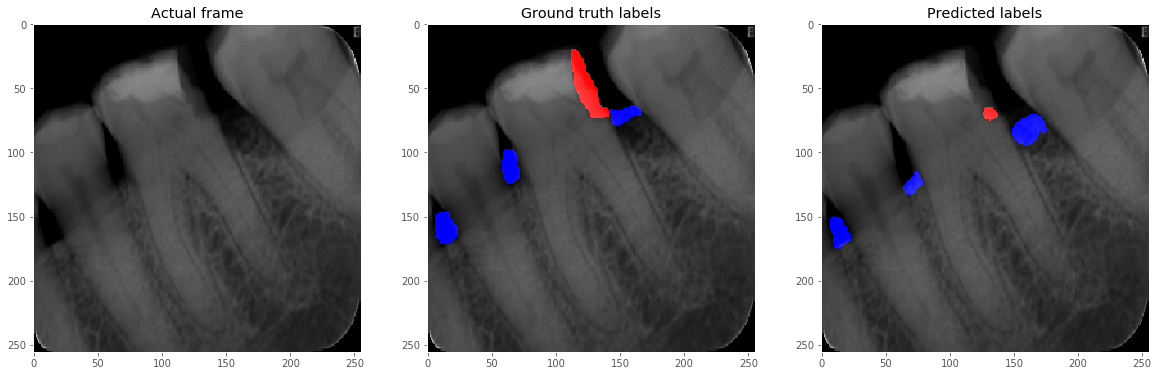

W0809 17:07:16.976342 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:16.995604 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


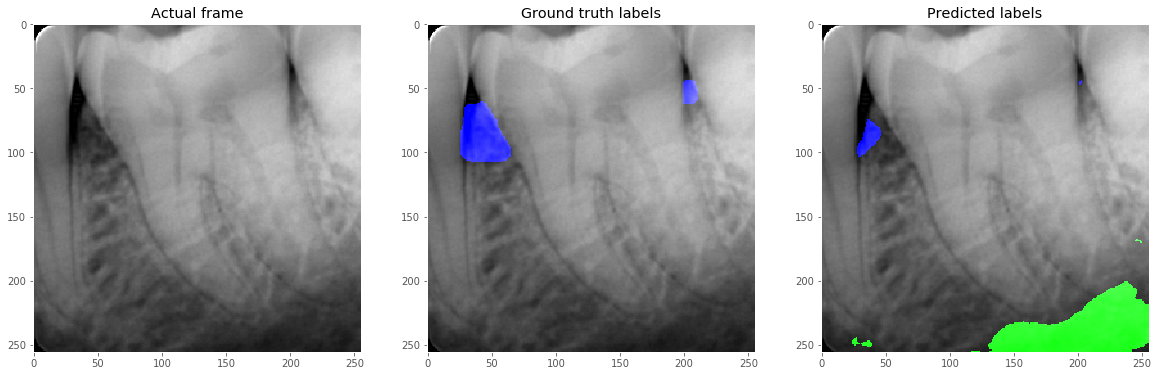

W0809 17:07:17.814541 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:17.837371 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


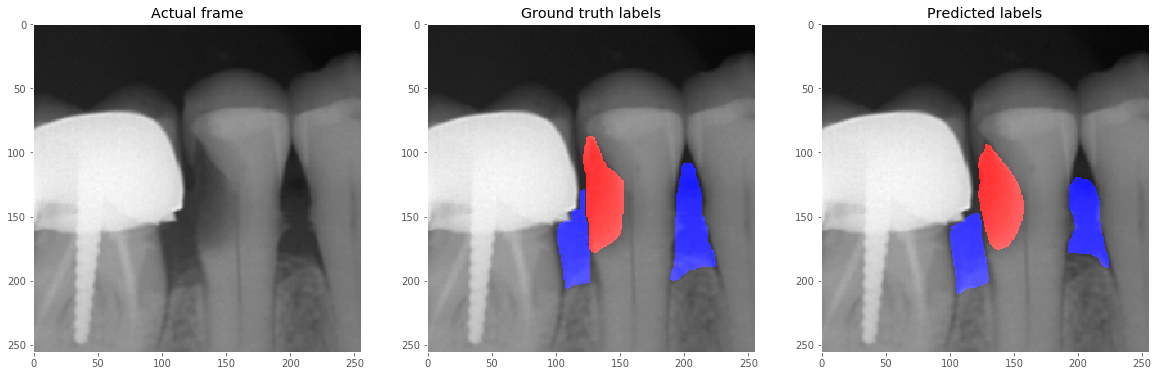

W0809 17:07:18.524540 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:18.542311 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


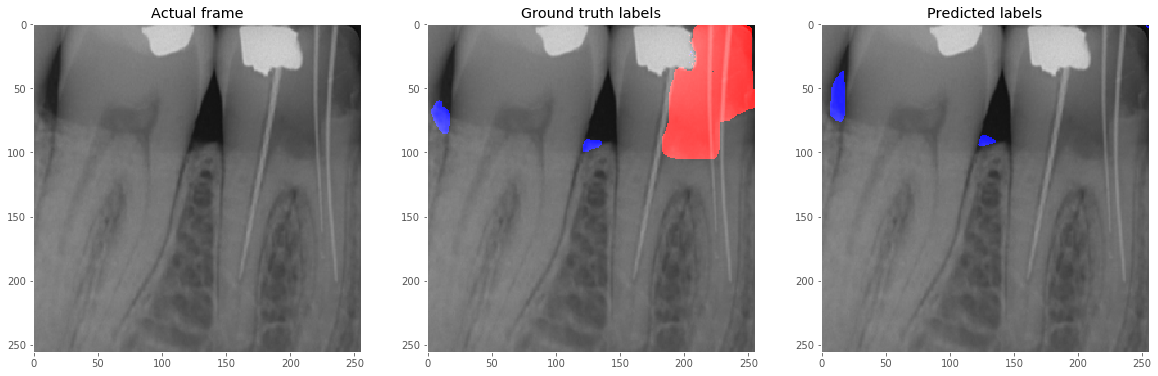

W0809 17:07:19.149356 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:19.171752 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


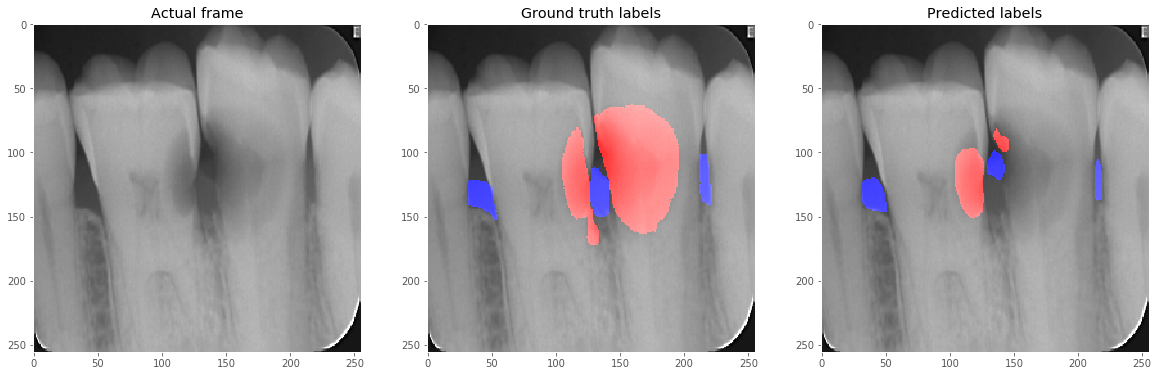

W0809 17:07:19.755068 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:19.772773 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


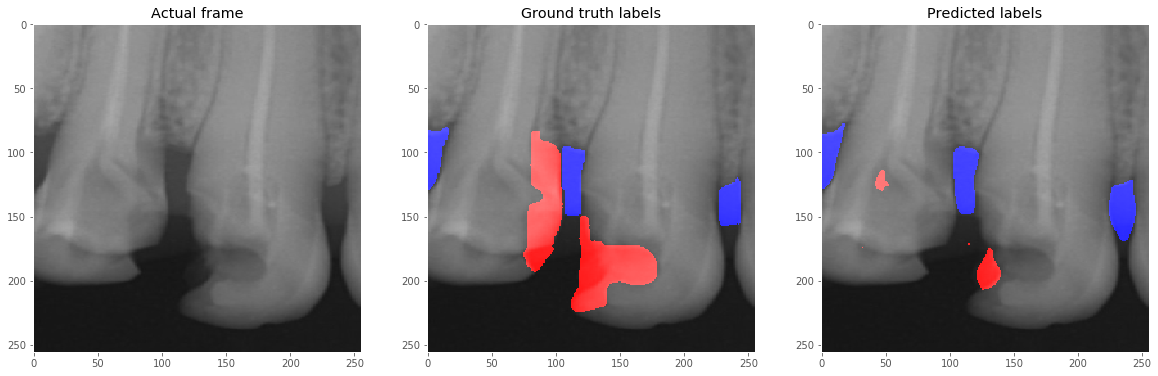

W0809 17:07:20.405096 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:20.448771 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


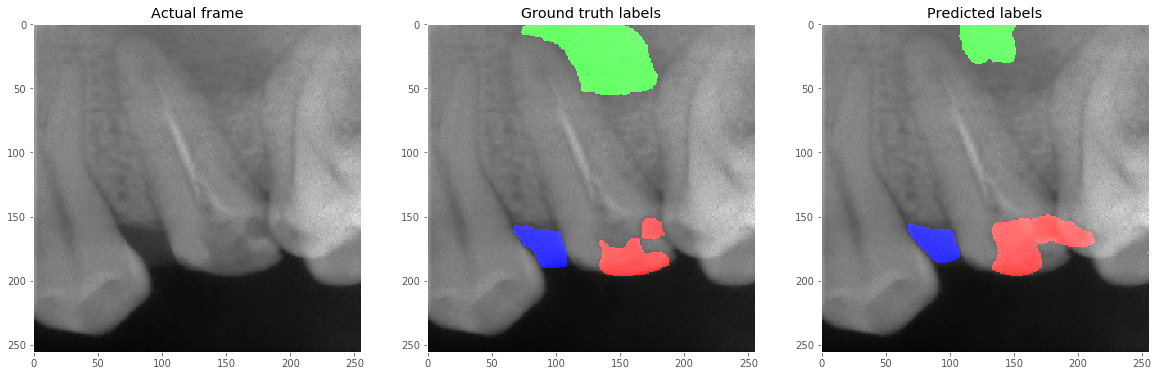

W0809 17:07:21.052075 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:21.079081 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


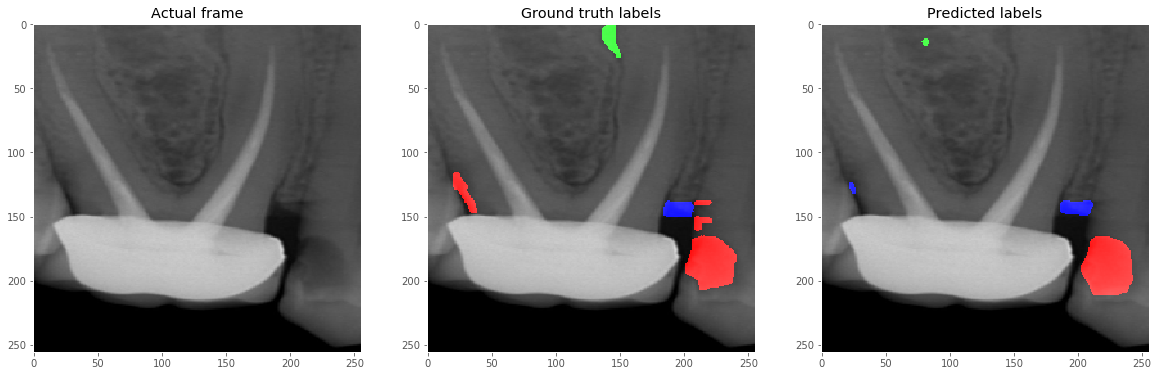

W0809 17:07:21.637769 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:21.674854 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


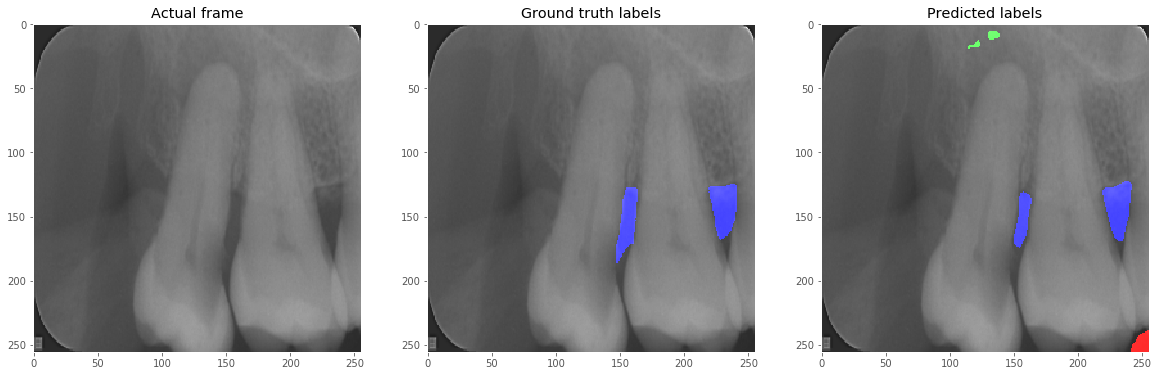

W0809 17:07:22.211008 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:22.251910 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


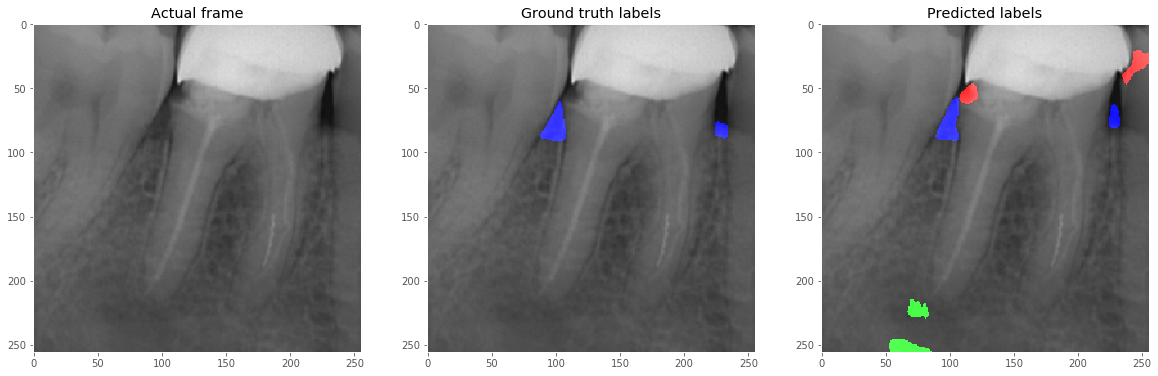

W0809 17:07:22.837986 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:22.875777 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


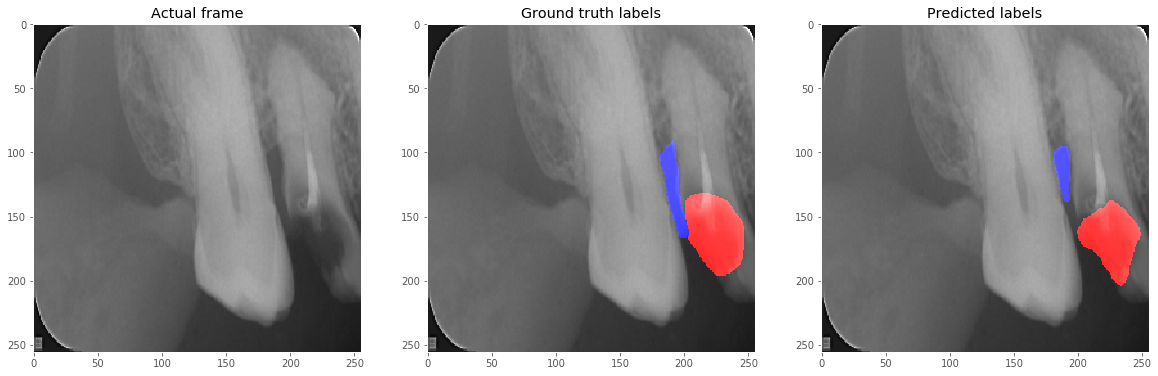

W0809 17:07:23.847232 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:23.873061 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


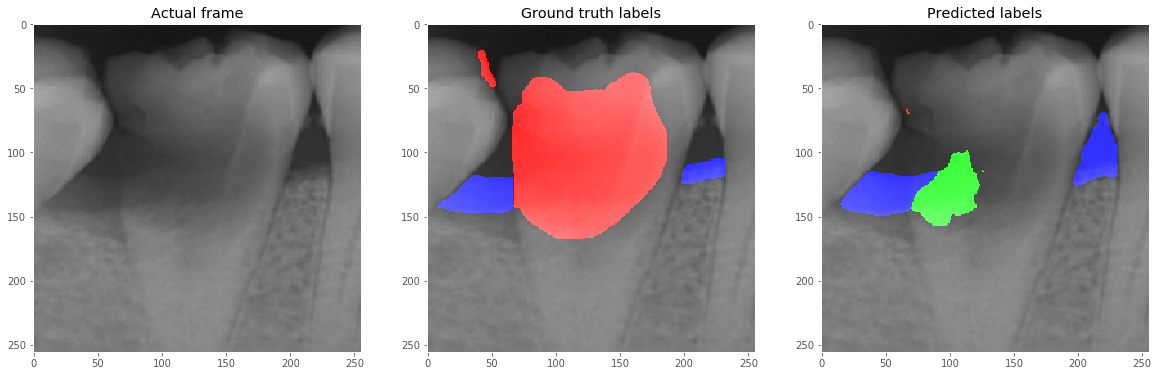

W0809 17:07:24.661197 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:24.682802 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


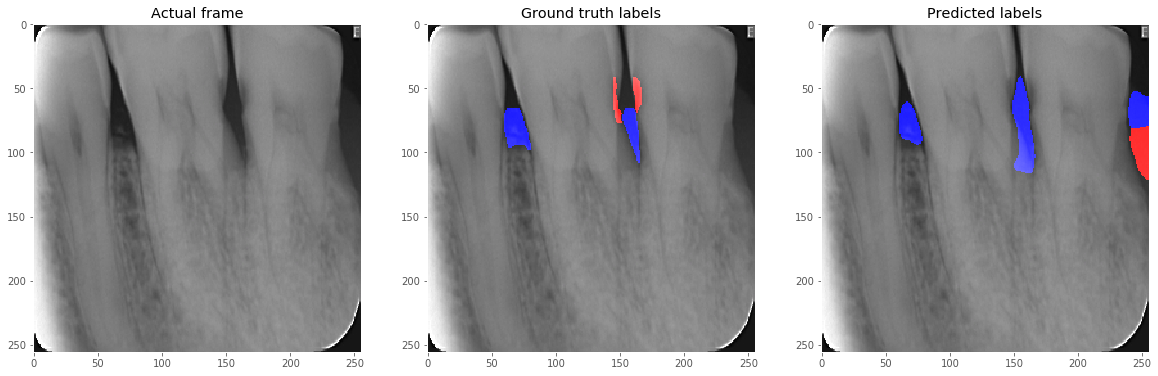

W0809 17:07:25.393984 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:25.412436 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


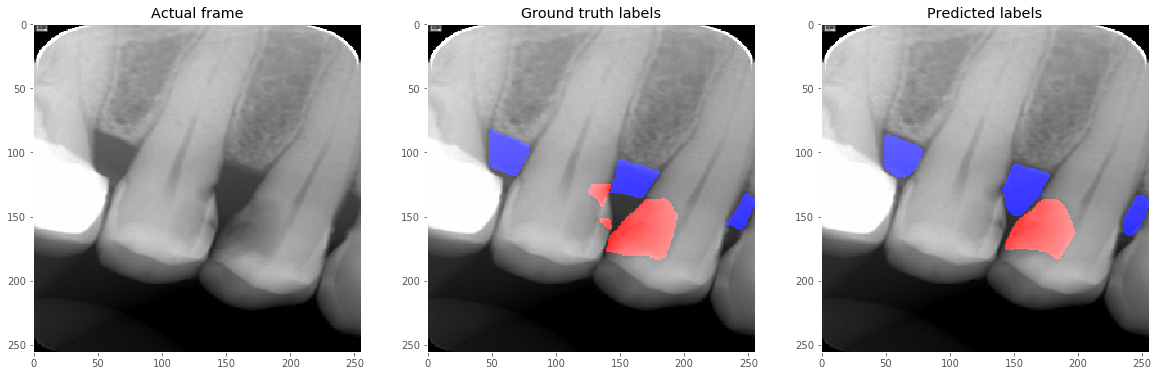

W0809 17:07:26.085029 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:26.111899 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


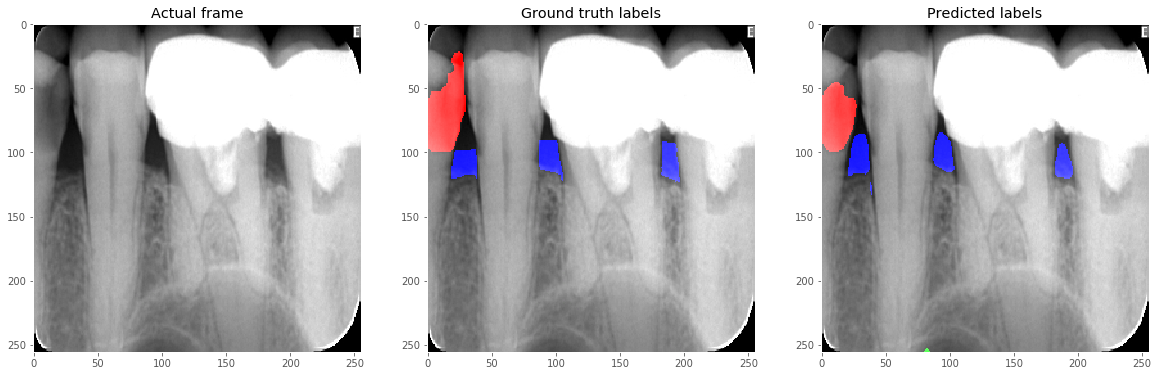

W0809 17:07:26.746996 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:26.766500 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


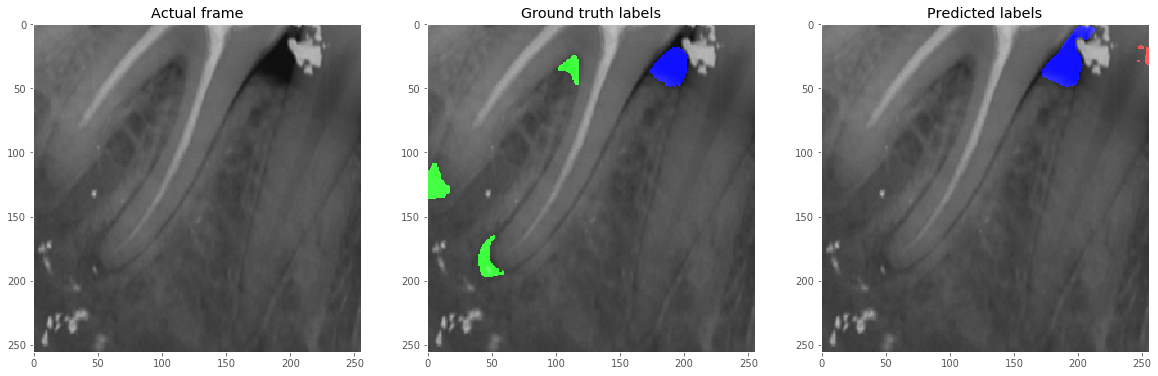

W0809 17:07:27.384237 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:27.403533 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


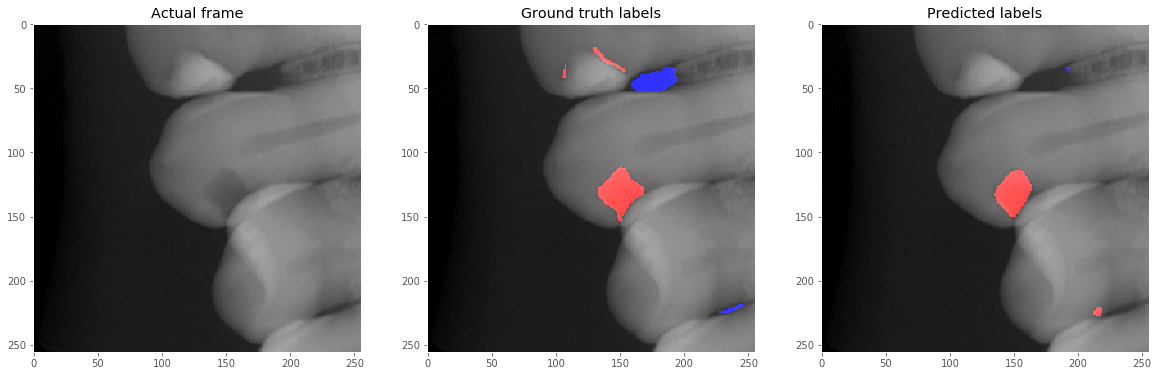

W0809 17:07:28.018013 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:28.045677 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


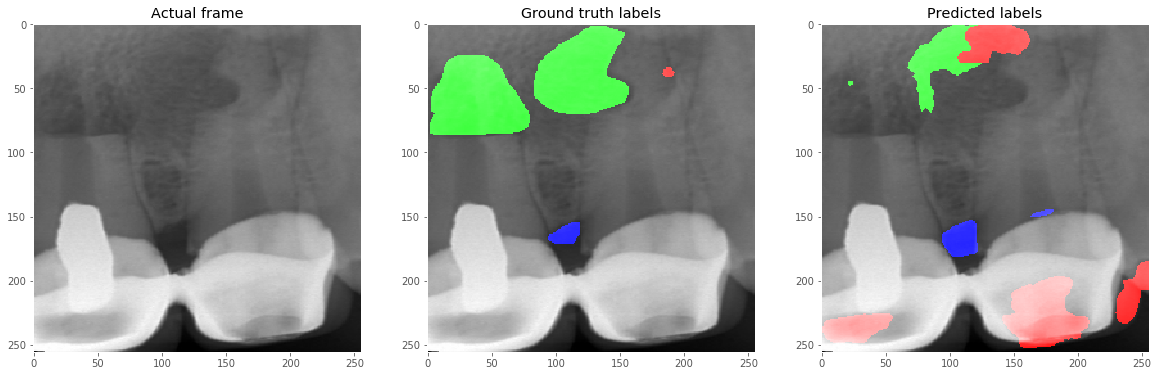

W0809 17:07:28.734560 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:28.753490 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


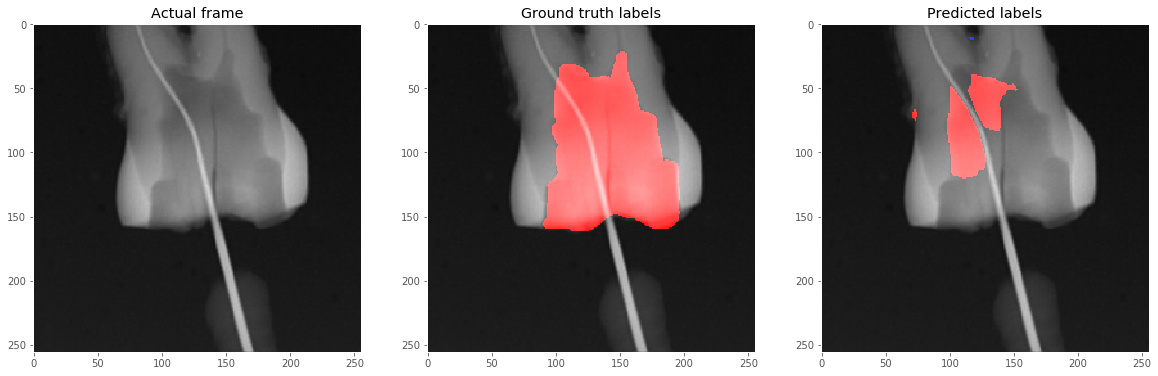

W0809 17:07:29.312825 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0809 17:07:29.351036 140184347899648 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


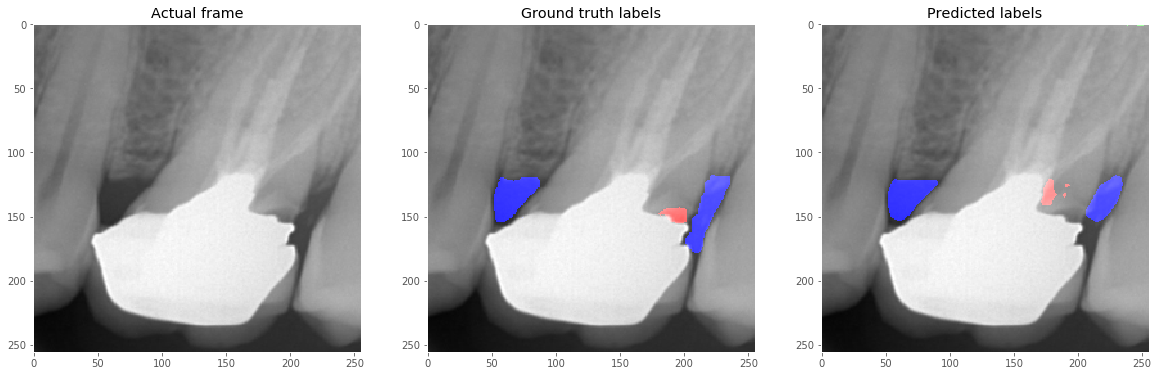

In [99]:
for i in range(0,np.shape(pred_all)[0]):
    
    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual frame')
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(np.maximum(batch_img[i],(onehot_to_rgb(batch_mask[i],id2code))))
    ax2.grid(b=None)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(np.maximum(batch_img[i],onehot_to_rgb(pred_all[i],id2code)))
    ax3.grid(b=None)
    
    plt.show()

## Displaying performance over defined metrics

#### Function for evaluating metrics on test images

In [67]:
def metrics_np(y_true, y_pred, metric_name, metric_type='standard', drop_last = True, mean_per_class=False, verbose=False):
    """ 
    Compute mean metrics of two segmentation masks, via numpy.
    
    IoU(A,B) = |A & B| / (| A U B|)
    Dice(A,B) = 2*|A & B| / (|A| + |B|)
    
    Args:
        y_true: true masks, one-hot encoded.
        y_pred: predicted masks, either softmax outputs, or one-hot encoded.
        metric_name: metric to be computed, either 'iou' or 'dice'.
        metric_type: one of 'standard' (default), 'soft', 'naive'.
          In the standard version, y_pred is one-hot encoded and the mean
          is taken only over classes that are present (in y_true or y_pred).
          The 'soft' version of the metrics are computed without one-hot 
          encoding y_pred.
          The 'naive' version return mean metrics where absent classes contribute
          to the class mean as 1.0 (instead of being dropped from the mean).
        drop_last = True: boolean flag to drop last class (usually reserved
          for background class in semantic segmentation)
        mean_per_class = False: return mean along batch axis for each class.
        verbose = False: print intermediate results such as intersection, union
          (as number of pixels).
    Returns:
        IoU/Dice of y_true and y_pred, as a float, unless mean_per_class == True
          in which case it returns the per-class metric, averaged over the batch.
    
    Inputs are B*W*H*N tensors, with
        B = batch size,
        W = width,
        H = height,
        N = number of classes
    """
    
    assert y_true.shape == y_pred.shape, 'Input masks should be same shape, instead are {}, {}'.format(y_true.shape, y_pred.shape)
    assert len(y_pred.shape) == 4, 'Inputs should be B*W*H*N tensors, instead have shape {}'.format(y_pred.shape)
    
    flag_soft = (metric_type == 'soft')
    flag_naive_mean = (metric_type == 'naive')
    
    num_classes = y_pred.shape[-1]
    # if only 1 class, there is no background class and it should never be dropped
    drop_last = drop_last and num_classes>1
    
    if not flag_soft:
        if num_classes>1:
            # get one-hot encoded masks from y_pred (true masks should already be in correct format, do it anyway)
            y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
            y_true = np.array([ np.argmax(y_true, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
        else:
            y_pred = (y_pred > 0).astype(int)
            y_true = (y_true > 0).astype(int)
    
    # intersection and union shapes are batch_size * n_classes (values = area in pixels)
    axes = (1,2) # W,H axes of each image
    intersection = np.sum(np.abs(y_pred * y_true), axis=axes) # or, np.logical_and(y_pred, y_true) for one-hot
    mask_sum = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
    union = mask_sum  - intersection # or, np.logical_or(y_pred, y_true) for one-hot
    
    if verbose:
        print('intersection (pred*true), intersection (pred&true), union (pred+true-inters), union (pred|true)')
        print(intersection, np.sum(np.logical_and(y_pred, y_true), axis=axes), union, np.sum(np.logical_or(y_pred, y_true), axis=axes))
    
    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    dice = 2*(intersection + smooth)/(mask_sum + smooth)
    
    metric = {'iou': iou, 'dice': dice}[metric_name]
    
    # define mask to be 0 when no pixels are present in either y_true or y_pred, 1 otherwise
    mask =  np.not_equal(union, 0).astype(int)
    # mask = 1 - np.equal(union, 0).astype(int) # True = 1
    
    if drop_last:
        metric = metric[:,1:]
        mask = mask[:,1:]
    
    # return mean metrics: remaining axes are (batch, classes)
    # if mean_per_class, average over batch axis only
    # if flag_naive_mean, average over absent classes too
    if mean_per_class:
        if flag_naive_mean:
            return np.mean(metric, axis=0)
        else:
            # mean only over non-absent classes in batch (still return 1 if class absent for whole batch)
            return (np.sum(metric * mask, axis=0) + smooth)/(np.sum(mask, axis=0) + smooth)
    else:
        if flag_naive_mean:
            return np.mean(metric)
        else:
            # mean only over non-absent classes
            class_count = np.sum(mask, axis=0)
            return np.mean(np.sum(metric * mask, axis=0)[class_count!=0]/(class_count[class_count!=0])+smooth)
        


#### Displaying results (mIoU)

In [97]:
bk = round(metrics_np(batch_mask[:,:,:,:1], y_p[:,:,:,:1], metric_name='iou'),6)
Red = round(metrics_np(batch_mask[:,:,:,1:2], y_p[:,:,:,1:2], metric_name='iou'),6)
Green = round(metrics_np(batch_mask[:,:,:,2:3], y_p[:,:,:,2:3], metric_name='iou'),6)
Blue = metrics_np(batch_mask[:,:,:,-1:], y_p[:,:,:,-1:], metric_name='iou')
overall_mean = (bk+Red+Green+Blue)/4
print('{:<60s} {:.3f}'.format('IoU of background:', bk))
print('{:<60s} {:.3f}'.format('IoU of Red class:', Red))
print('{:<60s} {:.3f}'.format('IoU of Green class:', Green))
print('{:<60s} {:.3f}'.format('IoU of Blue class:', Blue))
print('{:<60s} {}'.format('IoU of each class (explicit list):', [bk,Red,Green,Blue]))
print('{:<60s} {:.3f}'.format('mean IoU of all classes (no background):', metrics_np(batch_mask, y_p, metric_name='iou', metric_type='standard')))
print('{:<60s} {:.3f}'.format('mean IoU of all classes (with background):', overall_mean))
print('{:<60s} {:.3f}'.format('mean IoU of all non-absent classes (dropping background):', metrics_np(batch_mask, y_p, metric_name='iou')))

IoU of background:                                           0.950
IoU of Red class:                                            0.348
IoU of Green class:                                          0.101
IoU of Blue class:                                           0.448
IoU of each class (explicit list):                           [0.950262, 0.34823, 0.101389, 0.4484209759211734]
mean IoU of all classes (no background):                     0.299
mean IoU of all classes (with background):                   0.462
mean IoU of all non-absent classes (dropping background):    0.299


#### Displaying results (Dice Loss)

In [98]:
print('{:<60s} {:.3f}'.format('Dice of background:', metrics_np(batch_mask[:,:,:,:1], y_p[:,:,:,:1], metric_name='dice')))
print('{:<60s} {:.3f}'.format('Dice of Red class:', metrics_np(batch_mask[:,:,:,1:2], y_p[:,:,:,1:2], metric_name='dice')))
print('{:<60s} {:.3f}'.format('Dice of Green class:', metrics_np(batch_mask[:,:,:,2:3], y_p[:,:,:,2:3], metric_name='dice')))
print('{:<60s} {:.3f}'.format('Dice of Blue class:', metrics_np(batch_mask[:,:,:,-1:], y_p[:,:,:,-1:], metric_name='dice')))
print('{:<60s} {}'.format('Dice of each class (explicit list):', metrics_np(batch_mask, y_p, metric_name='dice', metric_type='standard', drop_last=False, mean_per_class=True)))
print('{:<60s} {:.3f}'.format('mean Dice of all classes (no background):', metrics_np(batch_mask, y_p, metric_name='dice', metric_type='standard')))
print('{:<60s} {:.3f}'.format('mean Dice of all classes (with background):', metrics_np(batch_mask, y_p, metric_name='dice', metric_type='standard', drop_last = False)))
print('{:<60s} {:.3f}'.format('mean Dice of all non-absent classes (dropping background):', metrics_np(batch_mask, y_p, metric_name='dice')))

Dice of background:                                          0.974
Dice of Red class:                                           0.431
Dice of Green class:                                         0.127
Dice of Blue class:                                          0.562
Dice of each class (explicit list):                          [0.97332014 0.42964065 0.12566308 0.5613924 ]
mean Dice of all classes (no background):                    0.373
mean Dice of all classes (with background):                  0.523
mean Dice of all non-absent classes (dropping background):   0.373


In [ ]:
import pandas as pd

In [ ]:
def onehot_to_id(encoded_image):
    max_args=np.argmax(encoded_image,axis=2)
    ids=np.hstack(max_args)
    return ids

In [ ]:
def confusion_matrix(batch_predicted,batch_actual):
    
    ids_predicted=[]
    ids_actual=[]
    for i in range(batch_predicted.shape[0]):
        arr_temp_pred=batch_predicted[i]
        arr_temp_actual=batch_actual[i]
        
        id_temp_predicted=onehot_to_id(arr_temp_pred)        
        id_temp_actual=onehot_to_id(arr_temp_actual)
        
        ids_predicted=np.append(ids_predicted,id_temp_predicted)
        ids_actual=np.append(ids_actual,id_temp_actual)
     
    y_pred = pd.Series(np.uint8(ids_predicted), name='Predicted')
    y_actu = pd.Series(np.uint8(ids_actual), name='Actual')
    df_confusion = pd.crosstab(y_actu, y_pred)
    return df_confusion

In [ ]:
df_confusion=confusion_matrix(y_p,batch_mask)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
print(df_conf_norm)

In [ ]:
def plot_confusion_matrix_colored(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

In [ ]:
plot_confusion_matrix_colored(df_confusion)